In [29]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

###  Can tissue associated microbiota profiles predict phenotype with greater accuracy than caecal content microbiota? 


In [30]:
# read in files and merge shannon.effective column from alpha-diverstiy table with otu table and classes from mapping file
def read_merge(otu, alpha_div, mapping, alpha_metric="Shannon.effective", mapping_classes="Phenotype"):
    otu_table = pd.read_table(otu, header=0, index_col=0).T
    mapping_file = pd.read_table(mapping, header=0, index_col=0)
    alpha_diversity = pd.read_table(alpha_div, header=0, index_col=0)
    merged = pd.concat([alpha_diversity[alpha_metric], otu_table, mapping_file[mapping_classes]], axis=1 )
    X = merged.drop(mapping_classes, axis=1)
    y= merged[mapping_classes]
    return X,y 

In [31]:
# merge caecal content files
X_cc, y_cc = read_merge("CC/OTUs_Table-norm-rel.tab", "CC/alpha-diversity.tab", "CC/mapping_file_wo_controls.tab")
# merge tissue associated files
X_tissue, y_tissue = read_merge("tissue/OTUs_Table-norm-rel.tab", "tissue/alpha-diversity.tab", "tissue/mapping_file_wo_controls.tab")

In [32]:
encoder = LabelEncoder()
y_cc = pd.Series(encoder.fit_transform(y_cc), index=y_cc.index, name=y_cc.name)
y_tissue = pd.Series(encoder.fit_transform(y_tissue), index=y_tissue.index, name=y_tissue.name)

### Classification 

**Random forest**

In [33]:
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, random_state=42)
X_train_tissue, X_test_tissue, y_train_tissue, y_test_tissue = train_test_split(X_tissue, y_tissue, random_state=42)

RFCC = RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1, oob_score=True)
RFT = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

RFCCmodel = RFCC.fit(X_train_cc, y_train_cc)
RFTmodel = RFT.fit(X_train_tissue, y_train_tissue)

In [34]:
RFCCpred = RFCCmodel.predict(X_test_cc)
RFTpred = RFTmodel.predict(X_test_tissue)
print("Predicted labels: ", RFCCpred)
print("Number of mislabeled points out of a total %d points : %d" % (X_test_cc.shape[0],( y_test_cc!= RFCCpred).sum()))
print("Predicted labels: ", RFTpred)
print("Number of mislabeled points out of a total %d points : %d" % (X_test_tissue.shape[0],( y_test_tissue!= RFTpred).sum()))

Predicted labels:  [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Number of mislabeled points out of a total 26 points : 4
Predicted labels:  [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1]
Number of mislabeled points out of a total 30 points : 4


In [35]:
kfold = KFold(n_splits=5, random_state=7)
modelCV = RandomForestClassifier()
scoring = 'accuracy'
results_cc = cross_val_score(modelCV, X_train_cc, y_train_cc, cv=kfold, scoring=scoring)
print("5-fold cross validation average accuracy: %.3f" % (results_cc.mean()))
results_tissue = cross_val_score(modelCV, X_train_tissue, y_train_tissue, cv=kfold, scoring=scoring)
print("5-fold cross validation average accuracy: %.3f" % (results_tissue.mean()))

5-fold cross validation average accuracy: 0.830
5-fold cross validation average accuracy: 0.806


In [36]:
print(confusion_matrix(y_test_cc, RFCCpred)) 
print(confusion_matrix(y_test_tissue, RFTpred))

[[18  0]
 [ 4  4]]
[[18  0]
 [ 4  8]]


Area Under the Curve:  0.75


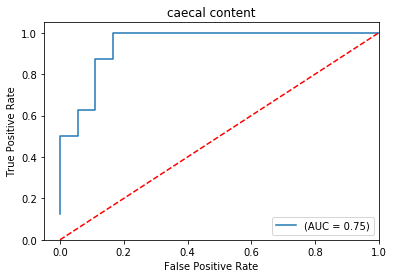

In [46]:
roc_auc_cc = roc_auc_score(y_test_cc, RFCCpred)
print("Area Under the Curve: ", roc_auc_cc)
fpr_cc, tpr_cc, thresholds_cc = roc_curve(y_test_cc, RFCCmodel.predict_proba(X_test_cc)[:,1])
plt.figure()
plt.plot(fpr_cc, tpr_cc, label='(AUC = %0.2f)' % roc_auc_cc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('caecal content')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_cc')
plt.show()

Area Under the Curve:  0.833333333333


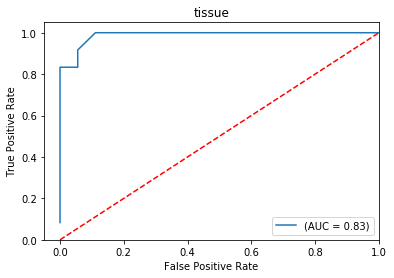

In [45]:
roc_auc_tissue = roc_auc_score(y_test_tissue, RFTpred)
print("Area Under the Curve: ", roc_auc_tissue)
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_tissue, RFTmodel.predict_proba(X_test_tissue)[:,1])
plt.figure()
plt.plot(fpr_t, tpr_t, label='(AUC = %0.2f)' % roc_auc_tissue)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('tissue')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_tissue')
plt.show()